In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

## Download do projeto

Clone o [repositório](https://github.com/rjribeiro/machine_learning)


## Configuração do ambiente


### Opção 1: [Docker](https://docs.docker.com/get-started/)
Execute ```bash run_jupyter.sh```

Esse comando irá buildar e executar uma imagem contendo docker contendo o jupyter. 
O diretório do projeto será todo mapeado para dentro de um container. 

    
### Opção 2: [Conda](https://docs.conda.io/en/latest/)
Execute ```conda env create -f conda_environment.yml python=3.10```


Em ambas as opções o Jupyter estará na porta http://127.0.0.1:8888


In [12]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from machine_learning.neighbors import KNeighborsClassifier
from machine_learning import model_selection, preprocessing, metrics, distance

In [6]:
df = pd.read_csv("../data/breast_cancer_data.csv", index_col=0)

## Questão 3.1 e 4

**Há uma grande diferença entre os valores máximo e mínimo de cada atributo?**

Sim, conforme mostrado no plot abaixo, principalmente entre os máximos.
Atributos com escalas maiores tendem a inviesar modelos de aprendizado de máquina baseados em distância.
Nesse casos é recomendado normalizar aos dados, trazendo os atributos para escalas semelhantes.
Nesse trabalho a normalização padrão é a Min-Max, conforme sugerido na especificação. Sua implentação pode ser conferida [aqui](https://github.com/rjribeiro/machine_learning/blob/f1a6c5dda3e3328781a57596a470b31fb41780bd/machine_learning/preprocessing.py).

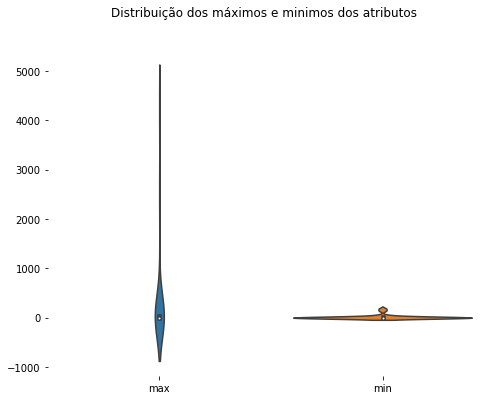

In [7]:
max_min = df.describe().transpose()[["max", "min"]]

f, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=max_min)
f.suptitle("Distribuição dos máximos e minimos dos atributos")
sns.despine(left=True, bottom=True)

## Questão 2 e 3.2

**Implemente uma função para fazer a divisão dos dados em treino e teste, de acordo com o método holdout. A proporção de dados mantida no conjunto de treinamento (ou, alternativamente, direcionada ao conjunto de teste) deve ser informada como parâmetro da função (por exemplo, prop_treino = 0.8 indicaria que 80% dos dados serão usados como conjunto de treinamento). A divisão dos dados deve ser estratificada**

Abaixo está o uso da função ```get_balanced_holdout``` que recebe o X e Y do dataset, a proporção de dados a ser utilizada para teste e o valor que configura o estado da biblioteca random.

A função ```get_balanced_holdout```, cujo código completo pode ser conferido [aqui](https://github.com/rjribeiro/machine_learning/blob/f1a6c5dda3e3328781a57596a470b31fb41780bd/machine_learning/model_selection.py#L7), implementa a divisão do dataset
entre treino e teste estratificando as classes alvo em cada conjunto.
No momento o código funciona somente para classes binárias.
Outro detalhe é que a variável seed ainda não demonstrou funcionar corretamente, ou seja, a cada execução da função são retornados conjuntos diferentes.

In [9]:
X = df.iloc[:, :-1]
y = df.target

X_train, X_test, y_train, y_test = model_selection.get_balanced_holdout(X, y, test_size=0.2, seed=42)

## Questão 3.3

**A partir dos dados de treinamento, classifique os dados de teste usando k=1, k=3, k=5, e k=7 (se desejar, avalie valores adicionais para k) com base na sua implementação. Avalie o desempenho do modelo usando a métrica de acurácia (taxa de acerto), reportando para cada valor de k a porcentagem de instâncias de teste classificadas corretamente.**

In [10]:
accuracies = []
Ks = [1, 3, 5, 7, 9, 11, 13]
for k in Ks:
    classifier = KNeighborsClassifier(k=k, distance_function=distance.get_euclidean_distance)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    accuracies.append((k, metrics.get_accuracy(y_test, predicted), 0))

    X_train_normalized = preprocessing.min_max_normalize(X_train)
    classifier.fit(X_train_normalized, y_train)
    X_test_normalized = preprocessing.min_max_normalize(X_test)
    predicted = classifier.predict(X_test_normalized)
    accuracies.append((k, metrics.get_accuracy(y_test, predicted), 1))

In [11]:
results = pd.DataFrame(data=accuracies, columns=["k", "accuracy", "is_normalized"])
results

,k,accuracy,is_normalized
0,1,0.877193,0
1,1,0.929825,1
2,3,0.885965,0
3,3,0.964912,1
4,5,0.894737,0
5,5,0.956140,1
6,7,0.877193,0
7,7,0.964912,1
8,9,0.885965,0
9,9,0.964912,1


## Questão 3.4

**Faça uma avaliação do resultado, brevemente discutindo os achados e se existe alguma tendência ou associação entre desempenho e valor de k.**

Análise dos resultados

 - De acordo com o plot abaixo, o melhor valor de K, para o conjunto de treino e teste configurado acima,  seria 13.
Importante resaltar que o melhor valor de K varia muito de acordo com o conjunto de treino e teste.
Em alguns testes o melhor K foi 3, em outros 7. Isso demonstra na prática o viés de busca.

 - Qualquer K com dataset normalizado sempre terá um resultado melhor do que qualquer K com dataset não normalizado. Para mim está claro o quanto a normalização é importante, principalmente em modelos de ML baseados em distância.

Avaliações mais precisas precisariam de:

  - Métodos de validação cruzada mais robustos como K-fold, Leave-one-Out, etc.


  - Métodos de otimização de hiperparâmetros mais robustos como GridSearch, BayesSearch, etc.

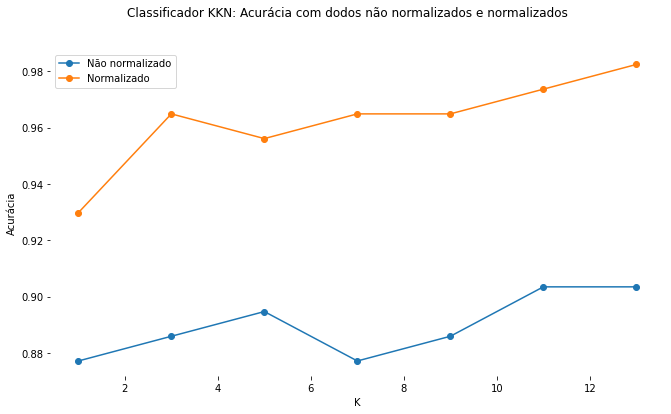

In [18]:
f, ax = plt.subplots(figsize=(11, 6))
results.groupby("is_normalized").plot(x="k", y="accuracy", marker="o", ax=ax)
f.suptitle("Classificador KKN: Acurácia com dodos não normalizados e normalizados")
plt.ylabel("Acurácia")
plt.xlabel("K")
plt.legend(["Não normalizado","Normalizado"])
sns.despine(left=True, bottom=True)